=== Running GPT-Powered PSO Optimization ===

[Round 1] Using PSO with swarmsize=10, maxiter=3, w=0.5, c1=1.0, c2=1.0
Stopping search: maximum iterations reached --> 3
GPT Reasoning: AUC scores seem to be similar across top parameter sets, implying we are close to an optimal configuration. Hence, we keep swarm size and maximum iterations to moderate values to balance exploration and exploitation of the search space. Reduced inertia weight encourages exploration, and increased cognitive and social coefficients emphasize individual and swarm intelligence, potentially allowing for more precise fine-tuning. 

[Round 2] Using PSO with swarmsize=19, maxiter=9, w=0.5, c1=2.0, c2=2.0
Stopping search: maximum iterations reached --> 9
GPT Reasoning: The AUC scores were similar across the parameter sets, indicating a good area of the search space but too much exploration might distort the optimization process. Hence, the swarmsize and maxiter are slightly increased to allow for a better search wi

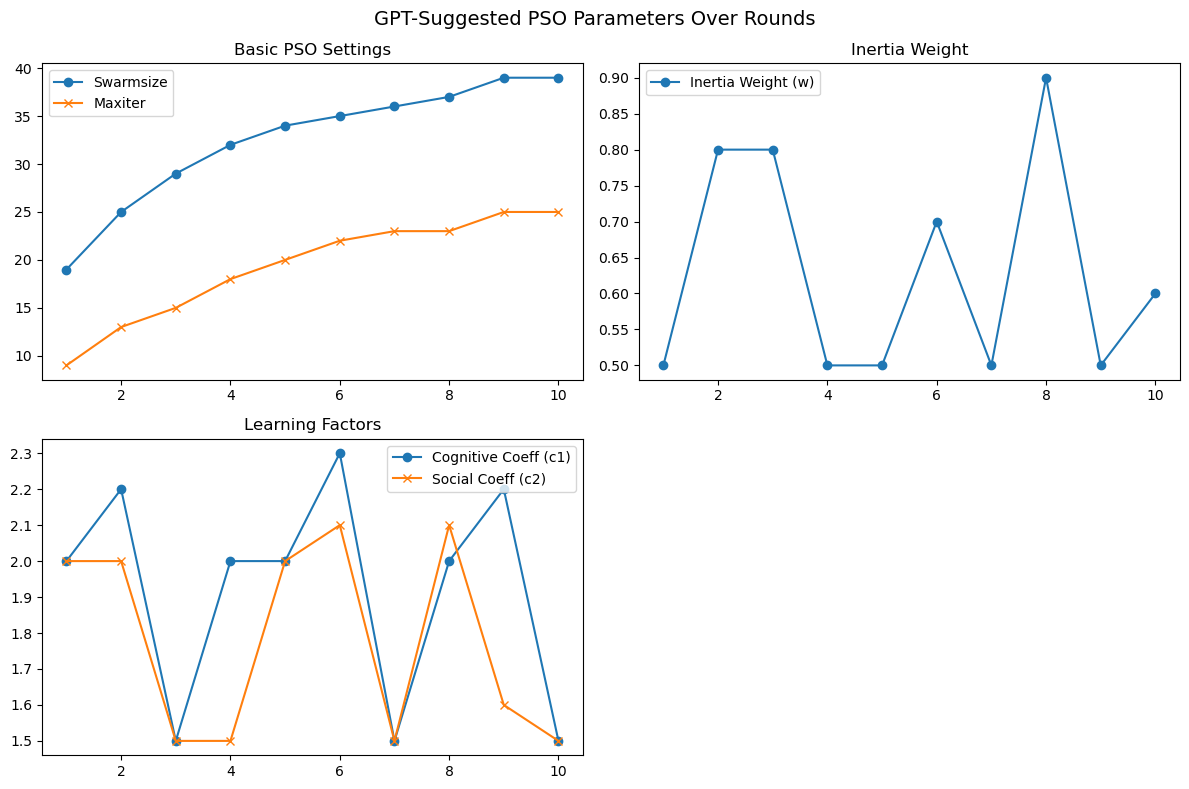

In [38]:
#  Section 1: Imports and Setup
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from pyswarm import pso
from dotenv import load_dotenv
from openai import OpenAI

#  Section 2: Load API Key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#  Section 3: Load and Prepare Dataset
df = pd.read_excel("default of credit card clients.xls", header=1)
X = df.drop(columns=["ID", "default payment next month"]).values
y = df["default payment next month"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#  Section 4: Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)

#  Section 5: PSO Runner (with EarlyStopping)
def run_pso_with_bounds(lb, ub, particles=10, iterations=3):
    history = []
    def eval_fn(params):
        hidden = int(params[0])
        lr = params[1]
        dropout = params[2]
        l2 = params[3]
        model = MLP(23, hidden, dropout)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

        best_auc = -np.inf
        no_improve = 0
        patience = 3
        best_state = None

        for epoch in range(20):
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(X_train), y_train)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                probs = torch.softmax(model(X_val), dim=1)[:, 1].numpy()
                val_auc = roc_auc_score(y_val.numpy(), probs)

            if val_auc > best_auc + 1e-4:
                best_auc = val_auc
                best_state = model.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        history.append({"hidden": hidden, "lr": lr, "dropout": dropout, "l2": l2, "auc": best_auc})
        return -best_auc

    pso(eval_fn, lb, ub, swarmsize=particles, maxiter=iterations)
    return history
    
#  Section 6: Build Prompt for GPT to Suggest PSO Meta-Parameters with Reasoning
def build_prompt_for_pso_settings(history, round_id):
    prompt = f"""You are helping optimize the PSO algorithm's own configuration. This is round {round_id} of using PSO to tune an MLP model.

Below are the top parameter sets from the previous search and their performance (AUC):
"""
    top = sorted(history, key=lambda x: -x["auc"])[:10]
    for i, row in enumerate(top):
        prompt += f"#{i+1}: hidden={row['hidden']}, lr={row['lr']:.5f}, dropout={row['dropout']:.2f}, l2={row['l2']:.5f} → AUC={row['auc']:.4f}\n"

    prompt += """Based on these results, recommend PSO settings for the next round including:
- swarmsize (int, ≤ 50)
- maxiter (int, ≤ 30)
- inertia_weight (float, 0.1–1.2)
- cognitive_coeff (float, 0.5–2.5)
- social_coeff (float, 0.5–2.5)

Also include a brief explanation for why you chose these values.

If AUC scores are similar across top parameter sets, you may keep PSO settings close to previous values to encourage stable convergence.

Respond only in JSON as: {\"swarmsize\": int, \"maxiter\": int, \"inertia_weight\": float, \"cognitive_coeff\": float, \"social_coeff\": float, \"reason\": \"...\"}

Please keep values within suggested ranges to ensure computational efficiency.
"""
    return prompt
#  Section 7: GPT API Caller for Extended PSO Settings with Reasoning

def call_gpt_to_update_pso_settings(prompt, round_id):
    with open(f"pso_meta_prompt_round_{round_id}.txt", "w") as f:
        f.write(prompt)

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a PSO meta-parameter tuning assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    msg = response.choices[0].message.content

    with open(f"pso_meta_response_round_{round_id}.json", "w") as f:
        f.write(msg)

    return json.loads(msg)


#  Section 8: Run Optimization Loop (LLM suggests PSO settings)
def run_meta_pso_optimization_loop(rounds=10):
    bounds = {
        "hidden": [20, 200],
        "lr": [0.0001, 0.01],
        "dropout": [0.1, 0.5],
        "l2": [0.00001, 0.01]
    }
    all_rounds = []
    bounds_history = []
    pso_settings_history = []

    swarmsize = 10
    maxiter = 3
    inertia_weight = 0.5
    cognitive_coeff = 1.0
    social_coeff = 1.0

    for r in range(rounds):
        print(f"\n[Round {r+1}] Using PSO with swarmsize={swarmsize}, maxiter={maxiter}, w={inertia_weight}, c1={cognitive_coeff}, c2={social_coeff}")
        history = run_pso_with_bounds(
            [bounds["hidden"][0], bounds["lr"][0], bounds["dropout"][0], bounds["l2"][0]],
            [bounds["hidden"][1], bounds["lr"][1], bounds["dropout"][1], bounds["l2"][1]],
            particles=swarmsize,
            iterations=maxiter
        )
        all_rounds.append(history)

        prompt = build_prompt_for_pso_settings(history, round_id=r+1)
        try:
            new_pso = call_gpt_to_update_pso_settings(prompt, round_id=r+1)
            swarmsize = int(0.7 * swarmsize + 0.3 * min(50, max(2, int(new_pso.get("swarmsize", swarmsize)))))
            maxiter = int(0.7 * maxiter + 0.3 * min(30, max(1, int(new_pso.get("maxiter", maxiter)))))
            inertia_weight = float(new_pso.get("inertia_weight", inertia_weight))
            cognitive_coeff = float(new_pso.get("cognitive_coeff", cognitive_coeff))
            social_coeff = float(new_pso.get("social_coeff", social_coeff))
            reason = new_pso.get("reason", "No explanation provided.")
            print(f"GPT Reasoning: {reason}")
        except Exception as e:
            print("[GPT Error] Using previous PSO settings:", e)

        pso_settings_history.append({
            "round": r+1,
            "swarmsize": swarmsize,
            "maxiter": maxiter,
            "inertia_weight": inertia_weight,
            "cognitive_coeff": cognitive_coeff,
            "social_coeff": social_coeff,
            "reason": reason
        })

    return all_rounds, pso_settings_history

#  Section 9: Visualize PSO Meta-Parameter Change Over Rounds (Extended)
def plot_pso_meta_trend(meta_history):
    rounds = [m["round"] for m in meta_history]
    swarms = [m["swarmsize"] for m in meta_history]
    iters = [m["maxiter"] for m in meta_history]
    ws = [m["inertia_weight"] for m in meta_history]
    c1s = [m["cognitive_coeff"] for m in meta_history]
    c2s = [m["social_coeff"] for m in meta_history]

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    ax[0, 0].plot(rounds, swarms, label="Swarmsize", marker='o')
    ax[0, 0].plot(rounds, iters, label="Maxiter", marker='x')
    ax[0, 0].set_title("Basic PSO Settings")
    ax[0, 0].legend()

    ax[0, 1].plot(rounds, ws, label="Inertia Weight (w)", marker='o')
    ax[0, 1].set_title("Inertia Weight")
    ax[0, 1].legend()

    ax[1, 0].plot(rounds, c1s, label="Cognitive Coeff (c1)", marker='o')
    ax[1, 0].plot(rounds, c2s, label="Social Coeff (c2)", marker='x')
    ax[1, 0].set_title("Learning Factors")
    ax[1, 0].legend()

    ax[1, 1].axis("off")
    plt.suptitle("GPT-Suggested PSO Parameters Over Rounds", fontsize=14)
    plt.tight_layout()
    plt.show()

#  Section 10: Final Model Evaluation
def evaluate_on_test_set(best_result):
    model = MLP(23, best_result['hidden'], best_result['dropout'])
    optimizer = optim.Adam(model.parameters(), lr=best_result['lr'], weight_decay=best_result['l2'])
    criterion = nn.CrossEntropyLoss()

    best_auc = -np.inf
    no_improve = 0
    patience = 5
    best_state = None

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            probs = torch.softmax(model(X_val), dim=1)[:, 1].numpy()
            val_auc = roc_auc_score(y_val.numpy(), probs)

        if val_auc > best_auc + 1e-4:
            best_auc = val_auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_test), dim=1)[:, 1].numpy()
        test_auc = roc_auc_score(y_test.numpy(), probs)

    print(f"\nFinal Test AUC (using best validation model): {test_auc:.4f}")

#  Section 11: Export Results
def export_results(all_rounds, filename):
    flat = [{**res, "round": r+1} for r, round in enumerate(all_rounds) for res in round]
    df = pd.DataFrame(flat)
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")
    return df

#  Section 12: Main Execution
if __name__ == "__main__":
    print("=== Running GPT-Powered PSO Optimization ===")
    all_results, meta_trend = run_meta_pso_optimization_loop(rounds=10)
    best_result = max([x for round in all_results for x in round], key=lambda x: x['auc'])
    print("Best Configuration Found:", best_result)
    evaluate_on_test_set(best_result)
    export_results(all_results, "llm_meta_pso_results.csv")
    plot_pso_meta_trend(meta_trend)

In [91]:
def run_fixed_pso_loop(rounds=10):
    print("=== Running Fixed-Config PSO (Looped for Comparison) ===")
    bounds = {
        "hidden": [20, 200],
        "lr": [0.0001, 0.01],
        "dropout": [0.1, 0.5],
        "l2": [0.00001, 0.01]
    }
    swarmsize = 20
    maxiter = 10
    all_fixed_rounds = []

    for r in range(rounds):
        print(f"[Fixed Round {r+1}] Running PSO with swarmsize={swarmsize}, maxiter={maxiter}")
        history = run_pso_with_bounds(
            [bounds["hidden"][0], bounds["lr"][0], bounds["dropout"][0], bounds["l2"][0]],
            [bounds["hidden"][1], bounds["lr"][1], bounds["dropout"][1], bounds["l2"][1]],
            particles=swarmsize,
            iterations=maxiter
        )
        all_fixed_rounds.append(history)

    return all_fixed_rounds

=== Running Fixed-Config PSO (Looped for Comparison) ===
[Fixed Round 1] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 2] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 3] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 4] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 5] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 6] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 7] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 8] Running PSO with swarmsize=20, maxiter=10
Stopping search: maximum iterations reached --> 10
[Fixed Round 9] Running PSO with swarmsize=20, maxiter=10
Stopping sear

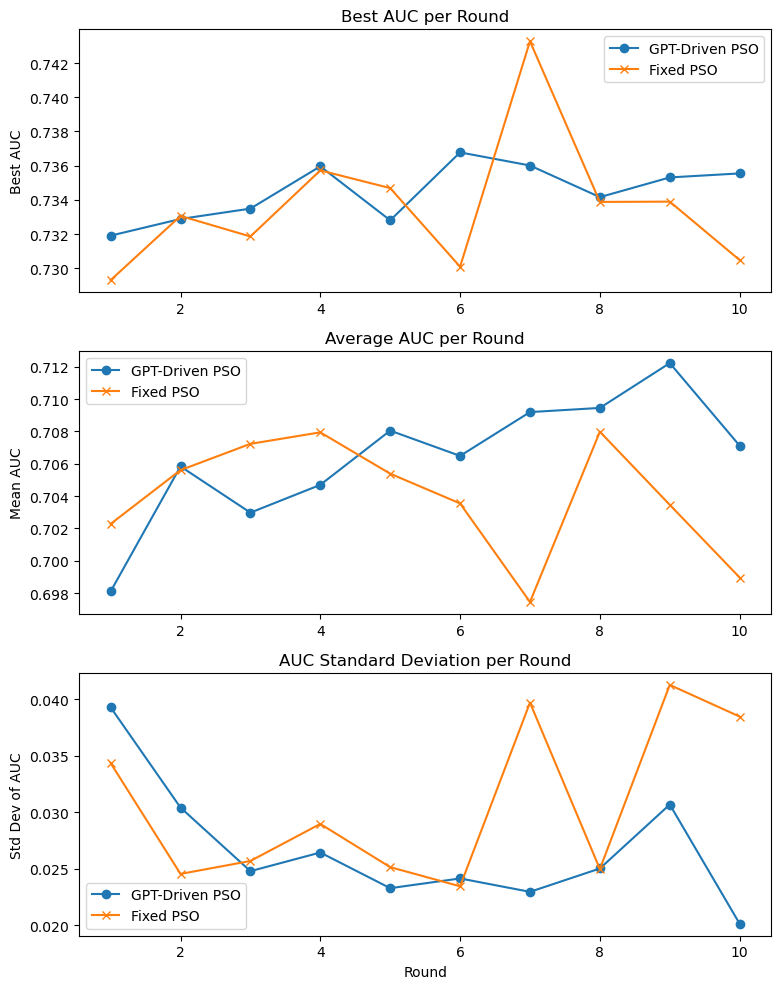

In [93]:
    # === Visualization Comparison ===
    import matplotlib.pyplot as plt
    def plot_auc_comparison(gpt_results, fixed_results):
        def get_stats_by_round(results):
            stats = []
            for round_data in results:
                aucs = [x['auc'] for x in round_data]
                stats.append({
                    'best': np.max(aucs),
                    'mean': np.mean(aucs),
                    'std': np.std(aucs)
                })
            return stats

        gpt_stats = get_stats_by_round(gpt_results)
        fixed_stats = get_stats_by_round(fixed_results)
        rounds = range(1, len(gpt_stats)+1)

        fig, axs = plt.subplots(3, 1, figsize=(8, 10))

        axs[0].plot(rounds, [s['best'] for s in gpt_stats], label='GPT-Driven PSO', marker='o')
        axs[0].plot(rounds, [s['best'] for s in fixed_stats], label='Fixed PSO', marker='x')
        axs[0].set_title('Best AUC per Round')
        axs[0].set_ylabel('Best AUC')
        axs[0].legend()

        axs[1].plot(rounds, [s['mean'] for s in gpt_stats], label='GPT-Driven PSO', marker='o')
        axs[1].plot(rounds, [s['mean'] for s in fixed_stats], label='Fixed PSO', marker='x')
        axs[1].set_title('Average AUC per Round')
        axs[1].set_ylabel('Mean AUC')
        axs[1].legend()

        axs[2].plot(rounds, [s['std'] for s in gpt_stats], label='GPT-Driven PSO', marker='o')
        axs[2].plot(rounds, [s['std'] for s in fixed_stats], label='Fixed PSO', marker='x')
        axs[2].set_title('AUC Standard Deviation per Round')
        axs[2].set_xlabel('Round')
        axs[2].set_ylabel('Std Dev of AUC')
        axs[2].legend()

        plt.tight_layout()
        plt.show()

    fixed_results = run_fixed_pso_loop(rounds=10)
best_fixed = max([x for round in fixed_results for x in round], key=lambda x: x['auc'])
print("Best Fixed PSO Configuration:", best_fixed)
evaluate_on_test_set(best_fixed)
export_results(fixed_results, "fixed_pso_results.csv")
    plot_auc_comparison(all_results, fixed_results)
